In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [3]:
# Data generators with rescaling
train_datagen_with_aug = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = train_datagen_with_aug.flow_from_directory(
    r"C:\Users\Hardik\Desktop\DR\Dataset\aptos2019-blindness-detection\train_split",
    target_size=(224, 224),  # Resize images to a fixed size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen_with_aug.flow_from_directory(
    r"C:\Users\Hardik\Desktop\DR\Dataset\aptos2019-blindness-detection\train_split",
    target_size=(224, 224),  # Resize images to a fixed size
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3298 images belonging to 5 classes.
Found 364 images belonging to 5 classes.


In [6]:
# Functional API for building the model
input_img = Input(shape=(224, 224, 3))
Xception_base = Xception(weights='imagenet', include_top=False, input_tensor=input_img)

# Freeze layers in DenseNet121
for layer in Xception_base.layers:
    layer.trainable = False

# Add custom layers on top of DenseNet121
x = Flatten()(Xception_base.output)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

# Construct the model
model = Model(inputs=input_img, outputs=output)

# Summary of the model
# model.summary()

# Compile the model
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

# Train the model
graph = model.fit(train_generator, epochs=25, validation_data=validation_generator)

# # Save the model
# model.save("/Users/hardikchhipa/Desktop/DR-Arvind/saved_models/used_models/densenet_121.h5")

# Print the results
print(graph.history)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/25


c:\Users\Hardik\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 312s 3s/step - accuracy: 0.5406 - f1_m: 0.5381 - loss: 14.0758 - precision_m: 0.5484 - recall_m: 0.5300 - val_accuracy: 0.7363 - val_f1_m: 0.7480 - val_loss: 0.7739 - val_precision_m: 0.8076 - val_recall_m: 0.6970
Epoch 2/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.7039 - f1_m: 0.6936 - loss: 0.8278 - precision_m: 0.7318 - recall_m: 0.6606 - val_accuracy: 0.7390 - val_f1_m: 0.7328 - val_loss: 0.7147 - val_precision_m: 0.7837 - val_recall_m: 0.6892
Epoch 3/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 301s 3s/step - accuracy: 0.7572 - f1_m: 0.7562 - loss: 0.6547 - precision_m: 0.8046 - recall_m: 0.7148 - val_accuracy: 0.7170 - val_f1_m: 0.7190 - val_loss: 0.7340 - val_precision_m: 0.7899 - val_recall_m: 0.6623
Epoch 4/25
104/104 ━━━━━━━━━━━━━━━━━━━━ 305s 3s/step - accuracy: 0.7697 - f1_m: 0.7718 - loss: 0.6342 - precision_m: 0.8160 - recall_m: 0.7336 - val_accuracy: 0.7720 - val_f1_m: 0.7796 - val_loss: 0.6104 - val_precision_m: 0.8441 - val_recall_m: 0.725

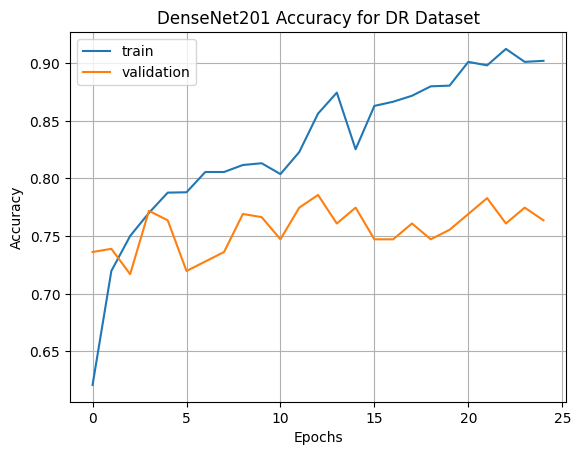

In [7]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['accuracy'])
plt.plot(graph.history['val_accuracy'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('DenseNet201 Accuracy for DR Dataset')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()

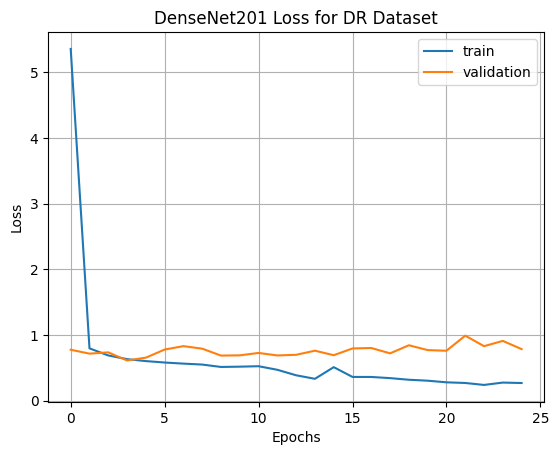

In [8]:
import matplotlib.pyplot as plt

fig1 = plt.gcf()

plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])

# plt.axis(ymin=0.4, ymax=1)
plt.grid()

plt.title('DenseNet201 Loss for DR Dataset')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','validation'])

plt.show()